In [176]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import dates
import pandas_ta as ta
import plotly.graph_objects as go
import plotly.express as px
from ta.momentum import RSIIndicator
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [177]:
data = pd.read_csv('./cotton/PCOTTINDUSDM.csv', parse_dates = True).round(2)
data.head()

,DATE,PCOTTINDUSDM
0,1990-01-01,75.20
1,1990-02-01,75.96
2,1990-03-01,78.90
3,1990-04-01,82.87
4,1990-05-01,85.60


In [178]:
data.tail()

,DATE,PCOTTINDUSDM
413,2024-06-01,83.24
414,2024-07-01,81.38
415,2024-08-01,79.93
416,2024-09-01,82.56
417,2024-10-01,83.69


In [179]:
data = data.rename(columns={'PCOTTINDUSDM': 'Cotton Price'})

In [180]:
fig = px.line(data, x='DATE', y='Cotton Price', title='Cotton Price in USD')
fig.update_layout(yaxis=dict(title=dict(text='USD')))
fig.show()

March 2011: https://www.ft.com/content/3d876e64-35c9-11e0-b67c-00144feabdc0

May 2022: https://www.cotlook.com/information-2/cotlook-monthly/may-2022-market-summary/#

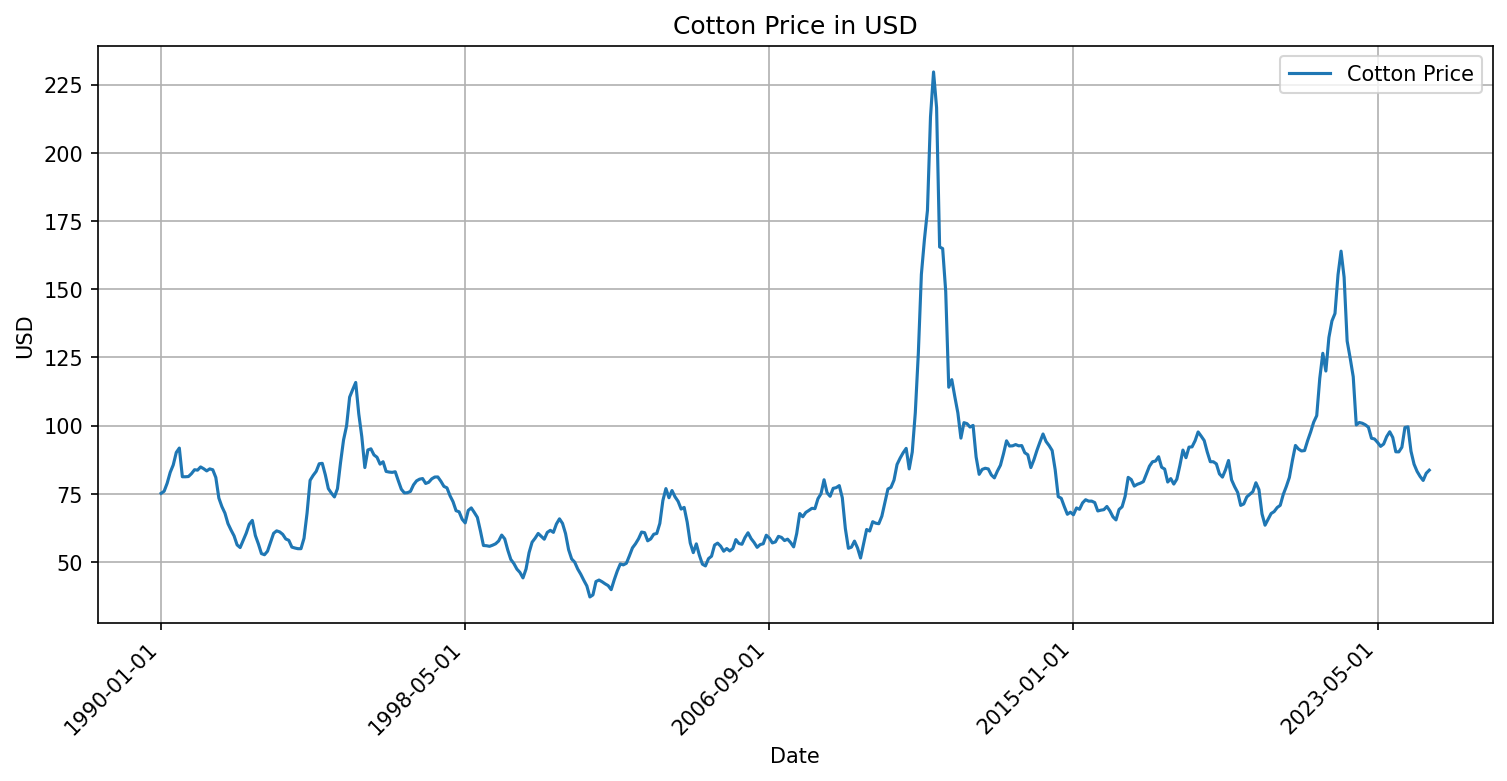

In [181]:
plt.figure(figsize=(12, 5), dpi=150)
ax = data.plot(x='DATE', y='Cotton Price', ax=plt.gca())
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Cotton Price in USD')

ax.xaxis.grid(True)
ax.yaxis.grid(True)

plt.show()


# 📊 Relative Strength Index (RSI)

## What is RSI?
- RSI is a momentum oscillator that measures speed and magnitude of price movements.
- **Range**: 0 to 100
  - **Above 70**: Overbought (potential sell signal).
  - **Below 30**: Oversold (potential buy signal).

## RSI Formula
1. **Relative Strength (RS)**:
   \[
   RS = \frac{\text{Average Gain}}{\text{Average Loss}}
   \]
2. **RSI**:
   \[
   RSI = 100 - \frac{100}{1 + RS}
   \]

---

## Key Points
- **Overbought (RSI > 70)**: Price may fall soon.
- **Oversold (RSI < 30)**: Price may rise soon.



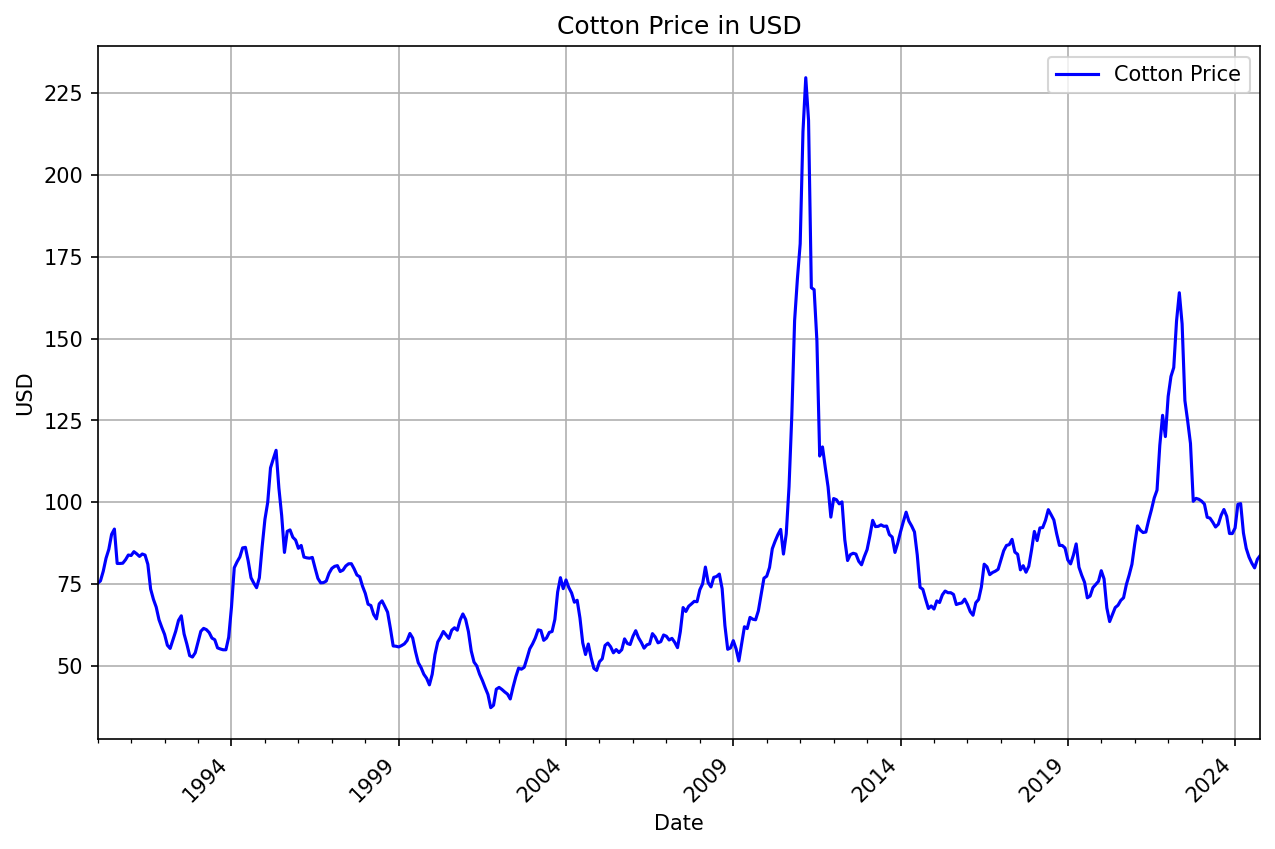

In [182]:
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

rsi_indicator = RSIIndicator(close=data["Cotton Price"], window=14)
data['RSI'] = rsi_indicator.rsi()

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=150)
data['Cotton Price'].plot(ax=ax1, color='blue', label='Cotton Price')
ax1.set_title('Cotton Price in USD')
ax1.set_xlabel('Date')
ax1.set_ylabel('USD')
ax1.grid(True)
ax1.legend()
plt.xticks(rotation=45, ha='right')

plt.show()

rsi_fig = go.Figure(data=[
    go.Scatter(x=data.index, y=data['RSI'], mode='lines', name='RSI', line=dict(color='blue'))
])

rsi_fig.update_layout(
    title='Cotton Price RSI',
    xaxis_title='Date',
    yaxis_title='RSI Value',
    xaxis_rangeslider_visible=False,
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)

rsi_fig.add_shape(type="line", x0=data.index.min(), y0=30, x1=data.index.max(), y1=30,
                  line=dict(color="green", dash="dash"), name="Oversold (30)")
rsi_fig.add_shape(type="line", x0=data.index.min(), y0=70, x1=data.index.max(), y1=70,
                  line=dict(color="red", dash="dash"), name="Overbought (70)")
rsi_fig.show()

# 📊 Moving Averages (M10 and M20)

## What are Moving Averages?
- **Moving Averages (MA)** are technical indicators that smooth out price data by calculating an average price over a specific period.
- They help identify trends by reducing short-term fluctuations.
- Types:
  - **M10 (10-Period Moving Average)**: Calculates the average of the last 10 periods.
  - **M20 (20-Period Moving Average)**: Calculates the average of the last 20 periods.

---

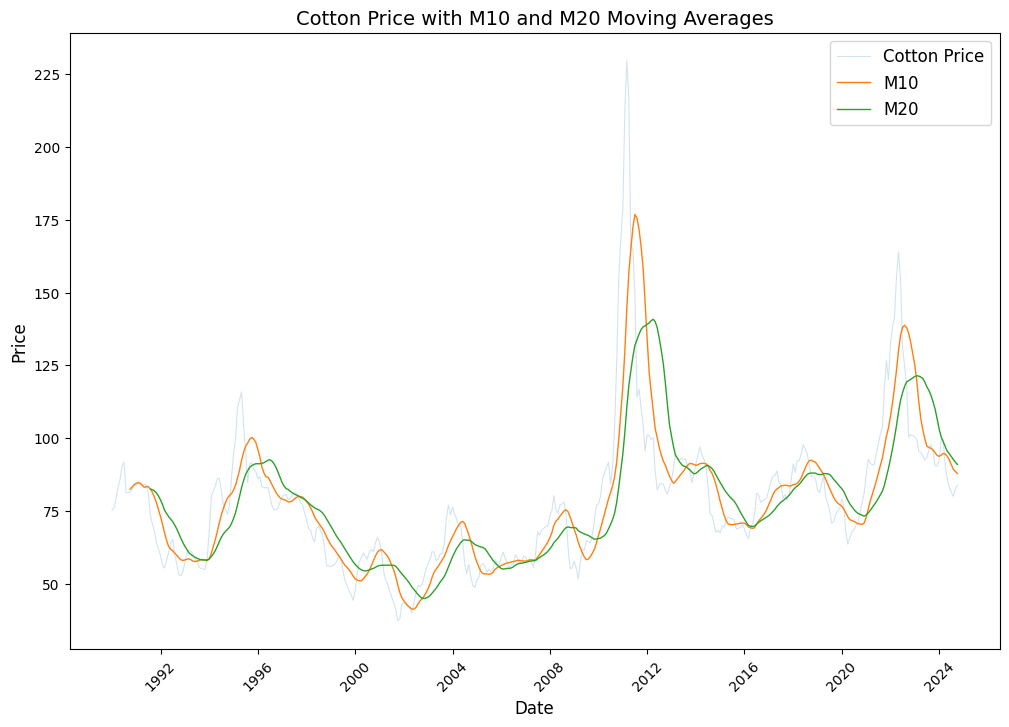

In [183]:
data['M10'] = data['Cotton Price'].rolling(window=10).mean()
data['M20'] = data['Cotton Price'].rolling(window=20).mean()

plt.figure(figsize=(12,8))
plt.plot(data.index, data['Cotton Price'], label='Cotton Price', linewidth=0.8, alpha=0.2)

plt.plot(data.index, data['M10'], label='M10', linewidth=1, alpha=1)
plt.plot(data.index, data['M20'], label='M20', linewidth=1, alpha=1)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Cotton Price with M10 and M20 Moving Averages', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.show()

# 📊 Bollinger Bands (BB)

## What Are Bollinger Bands?
- Volatility indicator with:
  - **Upper Band (UB)**: Middle Band + 2 standard deviations.
  - **Lower Band (LB)**: Middle Band - 2 standard deviations.
  - **Middle Band (MB)**: 20-period Moving Average.
- **Wider Bands** = High Volatility, **Narrower Bands** = Low Volatility.

---

## 📈 How to Use Bollinger Bands

### 🟥 **When Price Touches Upper Band**:
- **Interpretation**: Overbought (possible reversal).
- **Action**:
  - Consider selling or taking profits.
  - Confirm with RSI (>70 = overbought).

### 🟩 **When Price Touches Lower Band**:
- **Interpretation**: Oversold (possible rebound).
- **Action**:
  - Consider buying.
  - Confirm with RSI (<30 = oversold).

In [184]:
#Prepare and calculate BB
data['SD'] = data['Cotton Price'].rolling(window=20).std()
data['UB'] = data['M20'] + 2 * data['SD']
data['LB'] = data['M20'] - 2 * data['SD']

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['UB'], mode='lines', name='Upper Bollinger Band', visible=True, line=dict(color='red')))
fig.add_trace(go.Scatter(x=data.index, y=data['LB'], fill='tonexty', mode='lines', name='Lower Bollinger Band', visible=True, line=dict(color='green')))
fig.add_trace(go.Scatter(x=data.index, y=data['M20'], mode='lines', name='Middle Bollinger Band', visible=True, line=dict(color='blue')))
fig.add_trace(go.Scatter(x=data.index, y=data['Cotton Price'], mode='lines', name='Price (Bollinger)', visible=True, line=dict(color='black')))
fig.update_layout(
    xaxis_rangeslider_visible=False,
    yaxis_title='Cotton Price Bolinger Bands',
    xaxis_title='Date',
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)
fig.show()

# 📈 Prophet: Time Series Forecasting

## What is Prophet?
- **Prophet** is an open-source forecasting tool developed by Facebook for time series data.
- It is designed to handle:
  - **Trend**: Long-term increases or decreases.
  - **Seasonality**: Periodic patterns (daily, weekly, yearly).
  - **Holidays/Events**: Custom events that influence trends.

---

## Key Features
1. **Automatic Trend Detection**:
   - Identifies and models linear or non-linear trends with changepoints.
2. **Seasonality Handling**:
   - Captures weekly, monthly, and yearly seasonality patterns.
3. **Customizable**:
   - Supports adding external regressors, holidays, or custom seasonality.
4. **Robust to Missing Data**:
   - Handles missing data and outliers effectively.
5. **Interpretability**:
   - Outputs components of the forecast (trend, seasonality) for easy understanding.

---

## Prophet Workflow
1. **Prepare Data**:
   - Rename columns: `DATE` → `ds` (timestamp), `Value` → `y` (target).
2. **Fit Model**:
   - Train the model using historical data.
3. **Make Predictions**:
   - Generate future dates and forecast values.

---

In [185]:
data.reset_index(inplace=True)
prophet_data = data[['DATE', 'Cotton Price']].rename(columns={'DATE': 'ds', 'Cotton Price': 'y'})

prophet_model = Prophet()
prophet_model.fit(prophet_data)

future_dates = prophet_model.make_future_dataframe(periods=12, freq='MS')
forecast = prophet_model.predict(future_dates)

forecast[['ds', 'yhat']].tail(12)

10:41:29 - cmdstanpy - INFO - Chain [1] start processing
10:41:29 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
418,2024-11-01,94.169742
419,2024-12-01,96.210799
420,2025-01-01,99.528847
421,2025-02-01,103.501370
422,2025-03-01,101.379198
423,2025-04-01,101.406585
424,2025-05-01,100.570503
425,2025-06-01,100.199210
426,2025-07-01,98.683828
427,2025-08-01,96.047137


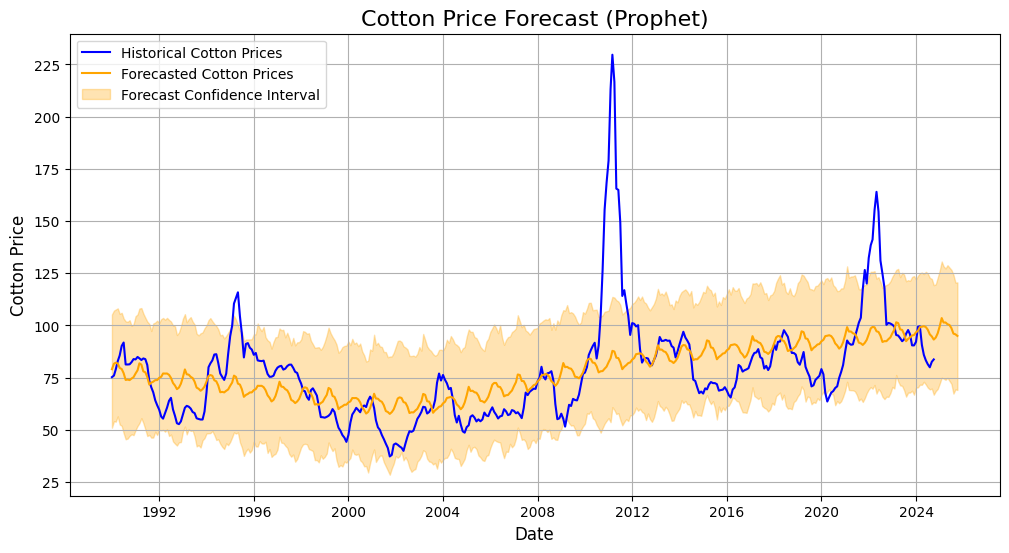

In [186]:
plt.figure(figsize=(12, 6))

plt.plot(prophet_data['ds'], prophet_data['y'], label='Historical Cotton Prices', color='blue')

plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Cotton Prices', color='orange')

plt.fill_between(
    forecast['ds'], 
    forecast['yhat_lower'], 
    forecast['yhat_upper'], 
    color='orange', 
    alpha=0.3, 
    label='Forecast Confidence Interval'
)

plt.title('Cotton Price Forecast (Prophet)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cotton Price', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

SARIMA (Seasonal)

In [187]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [188]:
data.set_index('DATE', inplace=True)
prices = data['Cotton Price']

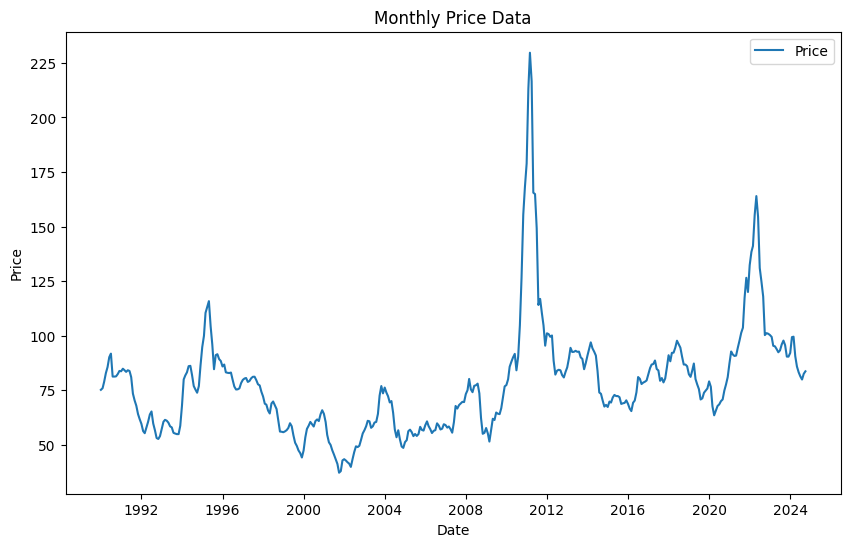

In [189]:
plt.figure(figsize=(10, 6))
plt.plot(prices, label='Price')
plt.title('Monthly Price Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [190]:
def check_stationarity(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

check_stationarity(prices)

ADF Statistic: -3.5025963255342885
p-value: 0.007920664748562898
The series is stationary.


<Figure size 1000x600 with 0 Axes>

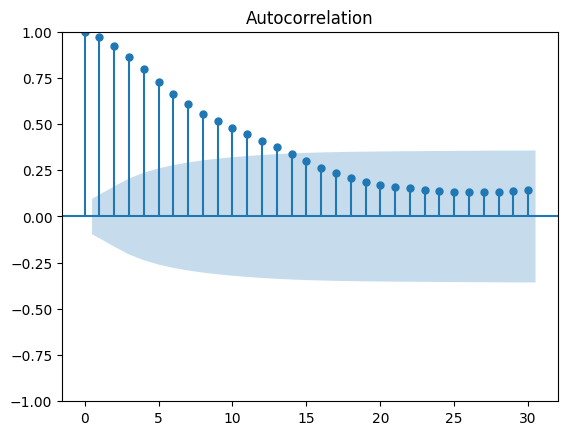

<Figure size 1000x600 with 0 Axes>

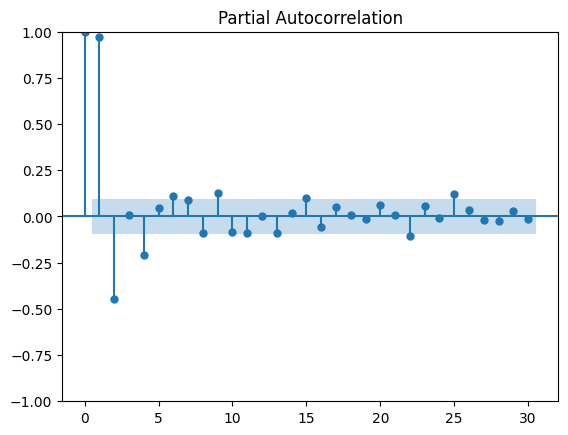

In [191]:
plt.figure(figsize=(10, 6))
plot_acf(prices, lags=30)
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(prices, lags=30)
plt.show()

In [192]:
model = SARIMAX(prices, 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 12), 
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit()
print(results.summary())

/opt/anaconda3/envs/DataScience/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/envs/DataScience/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                     SARIMAX Results                                      
Dep. Variable:                       Cotton Price   No. Observations:                  418
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1216.854
Date:                            Fri, 04 Apr 2025   AIC                           2443.708
Time:                                    10:41:30   BIC                           2463.552
Sample:                                01-01-1990   HQIC                          2451.574
                                     - 10-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0703      0.048      1.454      0.146      -0.024       0.165
ma.L1          0.3947      0.043   

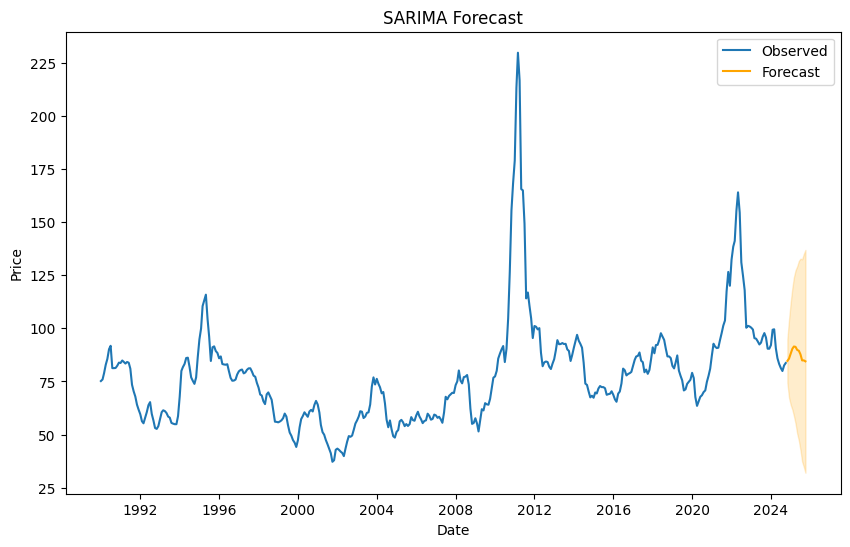

In [193]:
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=prices.index[-1], periods=forecast_steps + 1, freq='MS')[1:]
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(prices, label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='orange')
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='orange', alpha=0.2)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Simple LR

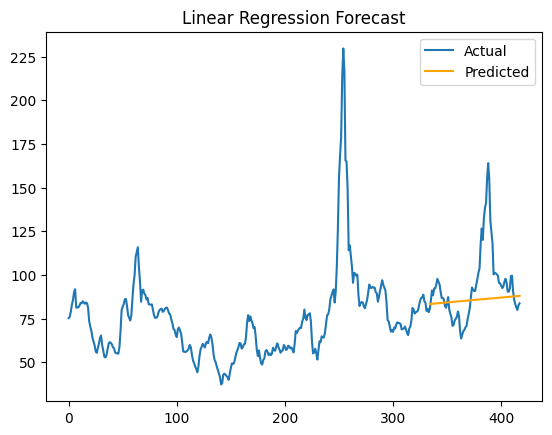

In [194]:
from sklearn.linear_model import LinearRegression

data.reset_index(inplace=True)
data['Time'] = range(len(data))
X = data[['Time']]
y = data['Cotton Price']

train_end = int(0.8 * len(data))
X_train, X_test = X[:train_end], X[train_end:]
y_train, y_test = y[:train_end], y[train_end:]

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

plt.plot(data.index, y, label="Actual")
plt.plot(data.index[train_end:], y_pred, label="Predicted", color='orange')
plt.title("Linear Regression Forecast")
plt.legend()
plt.show()

LSTM, Neural Nets

In [195]:
from sklearn.preprocessing import MinMaxScaler
from torch import nn
import torch

In [196]:
data.head()

,DATE,Cotton Price,RSI,M10,M20,SD,UB,LB,Time
0,1990-01-01,75.20,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1990-02-01,75.96,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1990-03-01,78.90,NaN,NaN,NaN,NaN,NaN,NaN,2
3,1990-04-01,82.87,NaN,NaN,NaN,NaN,NaN,NaN,3
4,1990-05-01,85.60,NaN,NaN,NaN,NaN,NaN,NaN,4


Epoch 1/20, Loss: 0.0108
Epoch 2/20, Loss: 0.0057
Epoch 3/20, Loss: 0.0043
Epoch 4/20, Loss: 0.0060
Epoch 5/20, Loss: 0.0034
Epoch 6/20, Loss: 0.0037
Epoch 7/20, Loss: 0.0022
Epoch 8/20, Loss: 0.0056
Epoch 9/20, Loss: 0.0010
Epoch 10/20, Loss: 0.0013
Epoch 11/20, Loss: 0.0010
Epoch 12/20, Loss: 0.0283
Epoch 13/20, Loss: 0.0193
Epoch 14/20, Loss: 0.0006
Epoch 15/20, Loss: 0.0014
Epoch 16/20, Loss: 0.0001
Epoch 17/20, Loss: 0.0047
Epoch 18/20, Loss: 0.0004
Epoch 19/20, Loss: 0.0003
Epoch 20/20, Loss: 0.0003


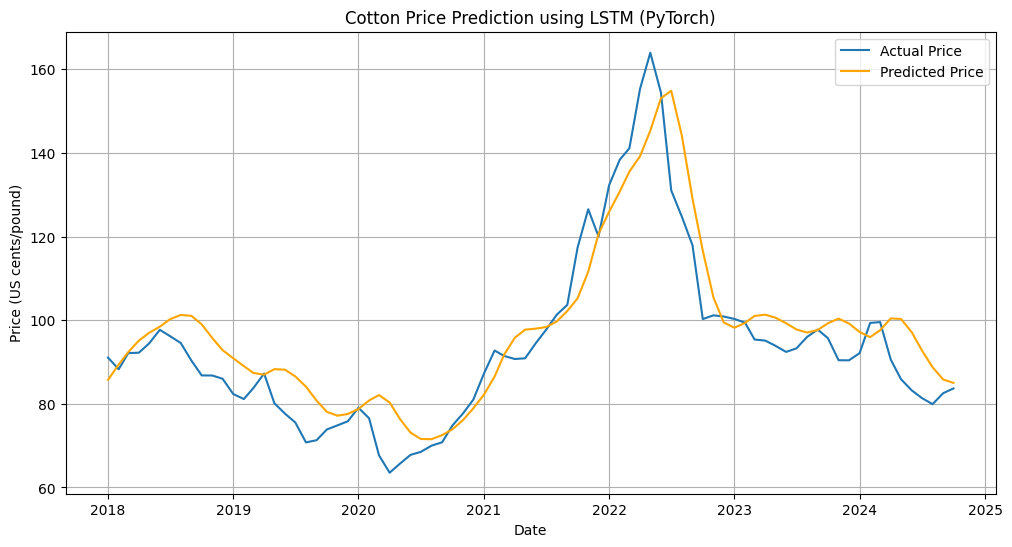

In [197]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Prepare the data

data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Cotton Price']])

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(scaled_data, seq_length)

# Reshape and split
X = X.reshape((X.shape[0], seq_length, 1))
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 20
batch_size = 16
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Make predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

# Inverse transform
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.numpy())

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_inv, label='Actual Price')
plt.plot(data.index[-len(y_test):], y_pred_inv, label='Predicted Price', color='orange')
plt.title('Cotton Price Prediction using LSTM (PyTorch)')
plt.xlabel('Date')
plt.ylabel('Price (US cents/pound)')
plt.legend()
plt.grid(True)
plt.show()


DATASETS:

https://www.emergingtextiles.com

https://tradingeconomics.com/commodity/cotton

https://fred.stlouisfed.org/series/PCOTTINDUSDM

https://www.statista.com/statistics/259431/global-cotton-price-since-1990/